In [12]:
#This is to import the library needed while some will be needed in the project.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
label_encoder = LabelEncoder()
scaler = StandardScaler()
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

In [13]:
# This line of code imports the data and converts it into a pandas dataframe

compas = pd.read_csv("/kaggle/input/compass/cox-violent-parsed.csv")

In [14]:
#This line of code will display the number of observations(rows) and features(columns) in the dataset
row,column=compas.shape
print(f"The compas dataset contain {row} rows and {column} columns")

The compas dataset contain 18316 rows and 52 columns


In [15]:
#This drop({[]}) will remove all the column listed that are not needed for the analysis

compas = compas.drop(['last','first','out_custody','in_custody','c_offense_date','decile_score.1','priors_count.1','c_case_number','days_b_screening_arrest','start','end','event','screening_date','c_case_number','juv_other_count','juv_misd_count','juv_fel_count','r_days_from_arrest','id','r_charge_degree','r_offense_date', 'vr_case_number','r_case_number','r_jail_out','c_arrest_date','r_charge_desc','r_jail_in', 'violent_recid','vr_charge_degree','vr_offense_date','vr_charge_desc'], axis=1)

In [16]:
#This is to change the data type from object to date

compas['c_jail_in'] = pd.to_datetime(compas['c_jail_in'])
compas['c_jail_out'] = pd.to_datetime(compas['c_jail_out'])
compas['days_in_jail'] = abs((compas['c_jail_out'] - compas['c_jail_in']).dt.days)
compas['compas_screening_date'] = pd.to_datetime(compas['compas_screening_date'])
compas['v_screening_date'] = pd.to_datetime(compas['v_screening_date'])

**SN------Variables------Details**

1	**name;**	The name of the defendant or individual.

2	**sex;**	Gender or sex of the defendant (e.g., Male, Female).

3	**dob;**	Date of birth of the defendant.

4	**age;**	Age of the defendant at the time of assessment.

5	**age_cat;**	Categorized age group of the defendant (e.g., "Less than 25", "25-45", "Greater than 45").

6	**race;**	Race or ethnicity of the defendant (e.g., Caucasian, African-American, Hispanic, etc.).

7	**decile_score;**	Risk score assigned by the COMPAS algorithm, indicating the defendant's perceived risk of recidivism    (ranges typically from 1 to 10, with 10 being the highest risk).

8	**priors_count;**	Number of prior criminal offenses or counts.

9	**c_jail_in;**	Date and time when the defendant was admitted to jail.

10	**c_jail_out;**	Date and time when the defendant was released from jail.

11	**c_days_from_compas;**	Number of days between the COMPAS assessment and the defendant's jail admission.

12	**c_charge_degree;**	Degree of criminal charge (e.g., Felony, Misdemeanor).

13	**c_charge_desc;**	Description of the criminal charge.

14	**is_recid;**	Binary indicator (0 or 1) whether the defendant was recidivated within a specific time frame.

15	**is_violent_recid;**	Binary indicator (0 or 1) whether the defendant's recidivism was violent in nature.

16	**type_of_assessment;**	Type of assessment conducted (e.g., Pretrial, Risk of Violence).

17	**score_text**	Textual representation of the risk score (e.g., "Low", "Medium", "High").

18	**screening_date;**	Date of the assessment screening.

19	**v_type_of_assessment;**	Type of violent risk assessment conducted.

20	**v_decile_score;**	Risk score assigned by the violent risk assessment.

21	**v_score_text;**	extual representation of the violent risk score.

22	**v_screening_date;**	Date of the violent risk assessment screening.

23	**days_in_jail;**	Days spent in jail.


In [17]:
# Impute missing values for numerical variables
numeric_cols = ['c_days_from_compas', 'v_decile_score']
for col in numeric_cols:
    compas[col].fillna(compas[col].median(), inplace=True)

# Impute missing values for categorical variables
categorical_cols = ['c_charge_degree', 'score_text', 'v_score_text', 'c_jail_in', 'c_jail_out', 'c_charge_desc', 'days_in_jail']
for col in categorical_cols:
    compas[col].fillna(compas[col].mode()[0], inplace=True)
compas = compas[compas['is_recid'] != -1].copy()
# Check if there are any missing values remaining
print(compas.isnull().sum())

name                     0
compas_screening_date    0
sex                      0
dob                      0
age                      0
age_cat                  0
race                     0
decile_score             0
priors_count             0
c_jail_in                0
c_jail_out               0
c_days_from_compas       0
c_charge_degree          0
c_charge_desc            0
is_recid                 0
is_violent_recid         0
type_of_assessment       0
score_text               0
v_type_of_assessment     0
v_decile_score           0
v_score_text             0
v_screening_date         0
days_in_jail             0
dtype: int64


In [18]:
#This provides a statistics summary of all data, excluding object, category etc

compas.describe()

,compas_screening_date,age,decile_score,priors_count,c_jail_in,c_jail_out,c_days_from_compas,is_recid,is_violent_recid,v_decile_score,v_screening_date,days_in_jail
count,17496,17496.000000,17496.000000,17496.000000,17496,17496,17496.000000,17496.000000,17496.000000,17496.000000,17496,17496.000000
mean,2013-11-22 08:52:00.987654144,33.950446,5.036123,4.096594,2013-11-19 18:35:46.454046464,2013-12-16 21:48:44.636488448,57.542295,0.481081,0.076532,4.049040,2013-11-22 08:52:00.987654144,24.385231
min,2013-01-01 00:00:00,18.000000,-1.000000,0.000000,2013-01-01 01:31:00,2013-01-02 01:12:00,0.000000,0.000000,0.000000,-1.000000,2013-01-01 00:00:00,0.000000
25%,2013-04-21 00:00:00,25.000000,2.000000,1.000000,2013-04-16 01:11:00,2013-05-06 04:12:00,1.000000,0.000000,0.000000,2.000000,2013-04-21 00:00:00,0.000000
50%,2013-11-08 00:00:00,31.000000,5.000000,2.000000,2013-11-04 04:07:30,2013-11-27 08:50:00,1.000000,0.000000,0.000000,4.000000,2013-11-08 00:00:00,1.000000
75%,2014-05-29 00:00:00,41.000000,8.000000,6.000000,2014-05-27 11:05:30,2014-06-21 08:45:45,2.000000,1.000000,0.000000,6.000000,2014-05-29 00:00:00,16.000000
max,2014-12-31 00:00:00,96.000000,10.000000,43.000000,2016-03-11 10:26:00,2020-01-01 00:00:00,9485.000000,1.000000,1.000000,10.000000,2014-12-31 00:00:00,2152.000000
std,NaN,11.602510,2.933318,5.352917,NaN,NaN,317.580822,0.499656,0.265855,2.616106,NaN,66.220286


### 3.Data_Visualisation

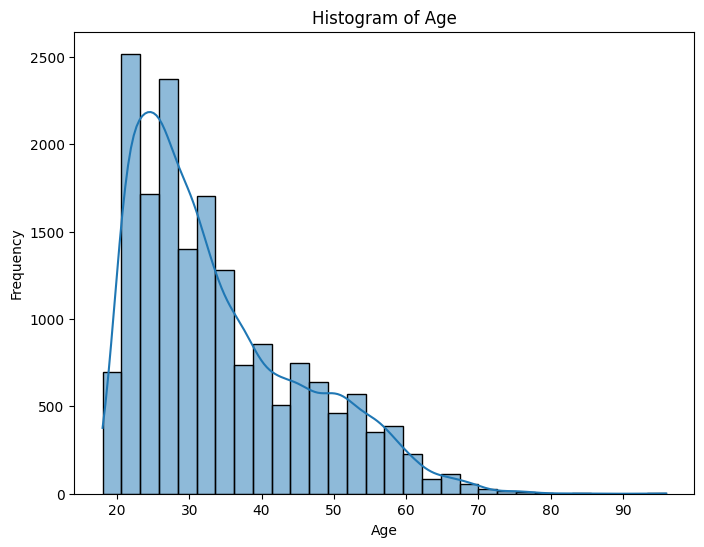

In [19]:
# Plot histogram of age
plt.figure(figsize=(8, 6))
sns.histplot(data=compas, x='age', bins=30, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

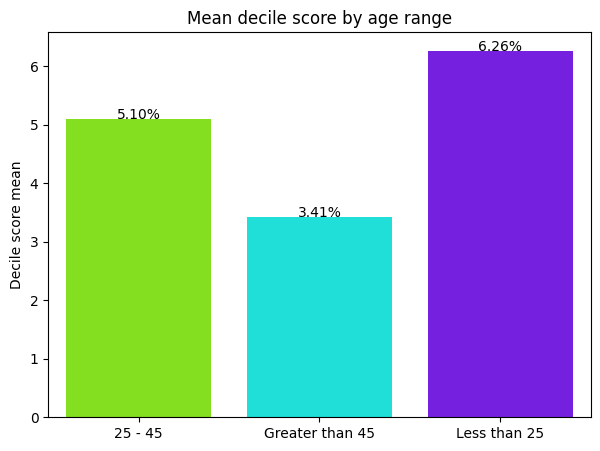

In [20]:
# Plot bar mean decile score of age range

decile_mean_age = compas.groupby("age_cat")["decile_score"].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.barplot(data=decile_mean_age, x="age_cat", y="decile_score", 
            palette=sns.color_palette("hsv", len(decile_mean_age)))

plt.ylabel("Decile score mean")
plt.xlabel("")
plt.title("Mean decile score by age range")

# Add percentage labels to each bar
for index, row in decile_mean_age.iterrows():
    plt.text(index, row['decile_score'], f"{row['decile_score']:.2f}%", 
             color='black', ha="center")

plt.show(block=False)

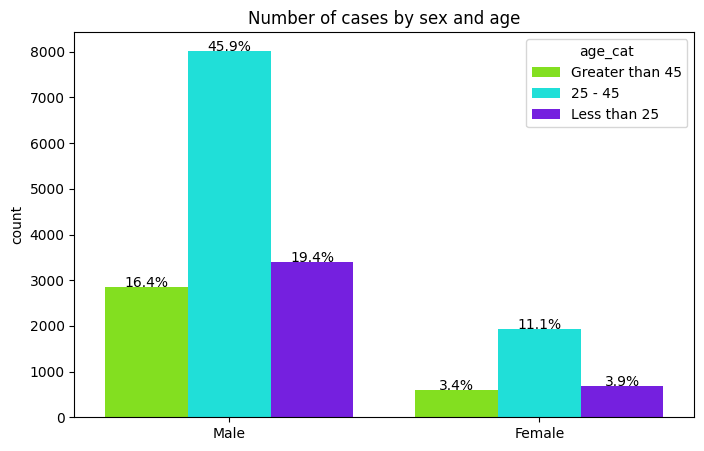

In [21]:
# Plot Count number of cases by sex and age

plt.figure(figsize=(8, 5)) 
ax = sns.countplot(data=compas, x="sex", hue="age_cat", palette=sns.color_palette("hsv", 3)) 
plt.title("Number of cases by sex and age") 
plt.xlabel("") 

# Calculate total count for each category
total_counts = compas.groupby(['sex', 'age_cat']).size().reset_index(name='total_count')

# Add percentage labels to each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, f'{100 * height / total_counts["total_count"].sum():.1f}%', ha="center")

plt.show(block=False)

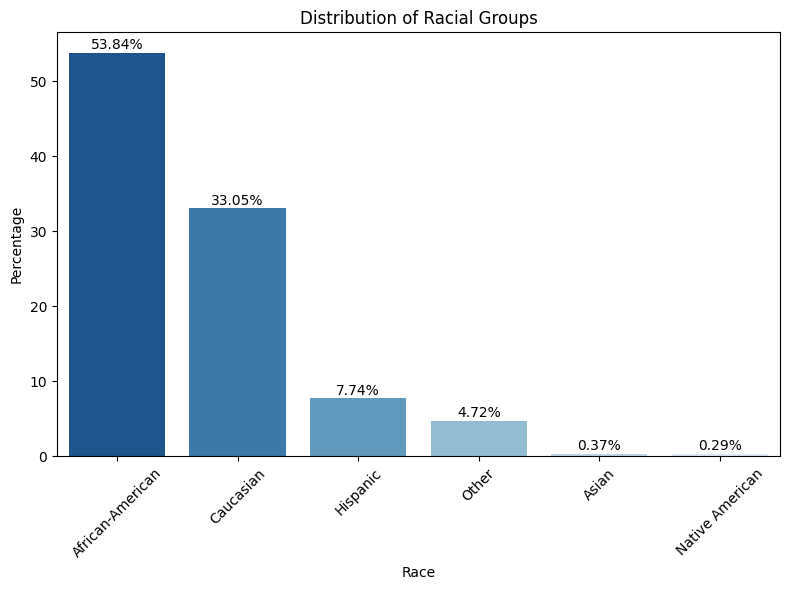

In [22]:
# Calculate percentage of each race
race_percentage = compas['race'].value_counts(normalize=True) * 100

# Sort races by count in descending order
race_percentage = race_percentage.sort_values(ascending=False)

# Visualize race distribution with percentage labels
plt.figure(figsize=(8, 6))
sns.barplot(x=race_percentage.index, y=race_percentage.values, palette="Blues_r")

# Add percentage labels to each bar
for i, val in enumerate(race_percentage.values):
    plt.text(i, val + 0.5, f"{val:.2f}%", ha="center")

plt.title('Distribution of Racial Groups')
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

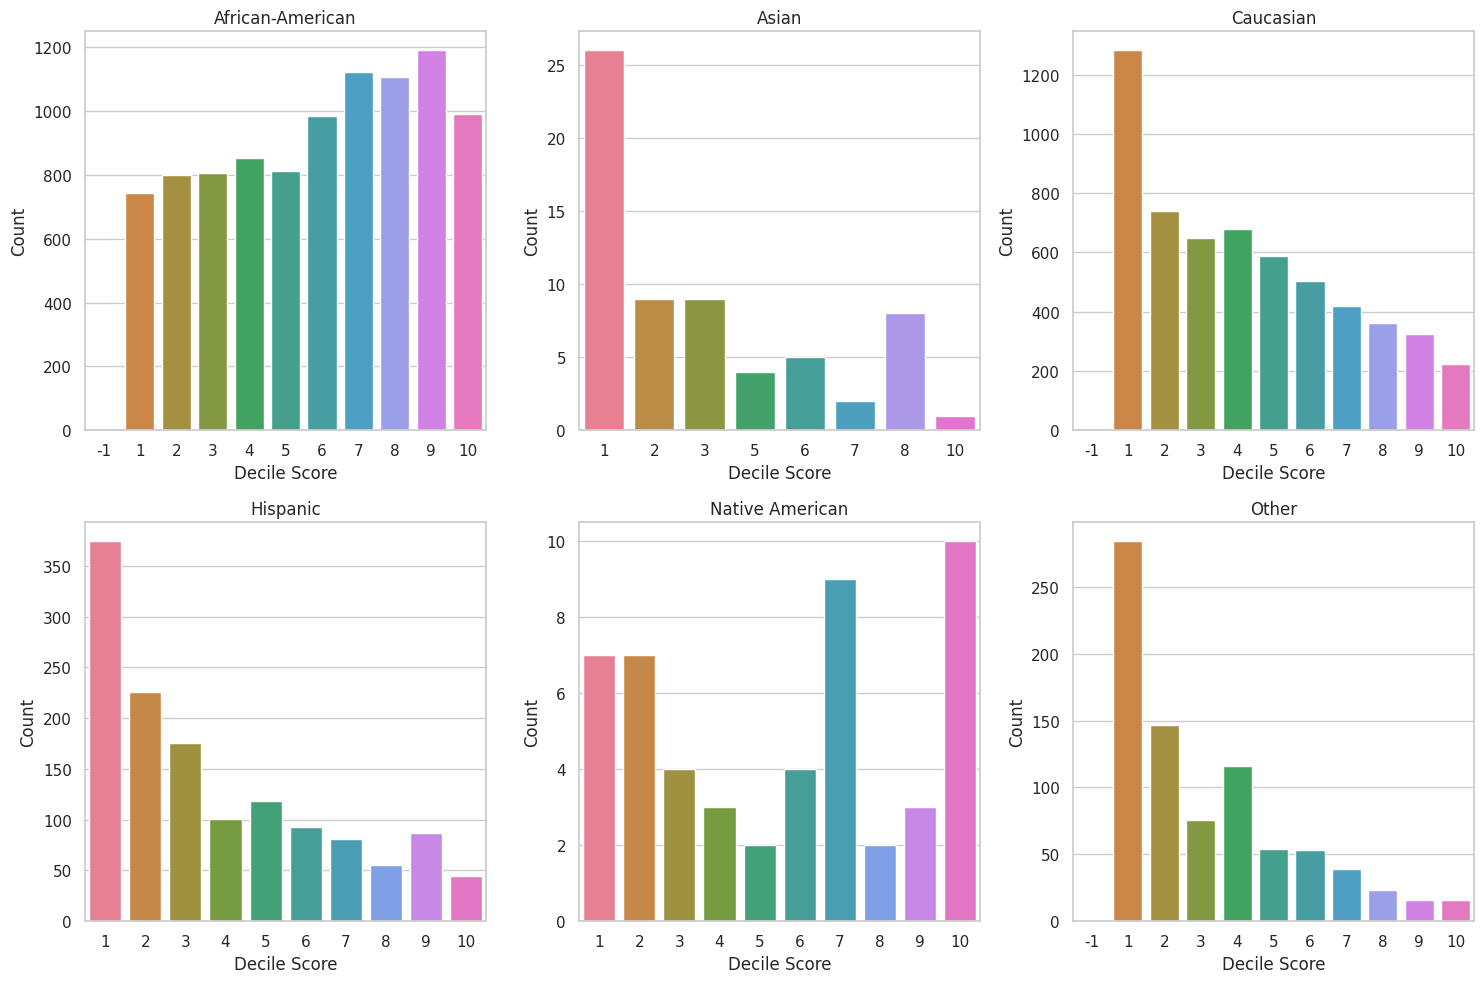

In [23]:
# Define a list of racial groups
racial_groups = ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a grid of count plots for each race's decile scores
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, race in enumerate(racial_groups):
    # Filter the dataframe for the current racial group
    race_data = compas[compas['race'] == race]
    
    # Create a count plot for the decile scores of the current racial group
    sns.countplot(x='decile_score', data=race_data, ax=axes[i], palette='husl')
    axes[i].set_title(race)
    axes[i].set_xlabel('Decile Score')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

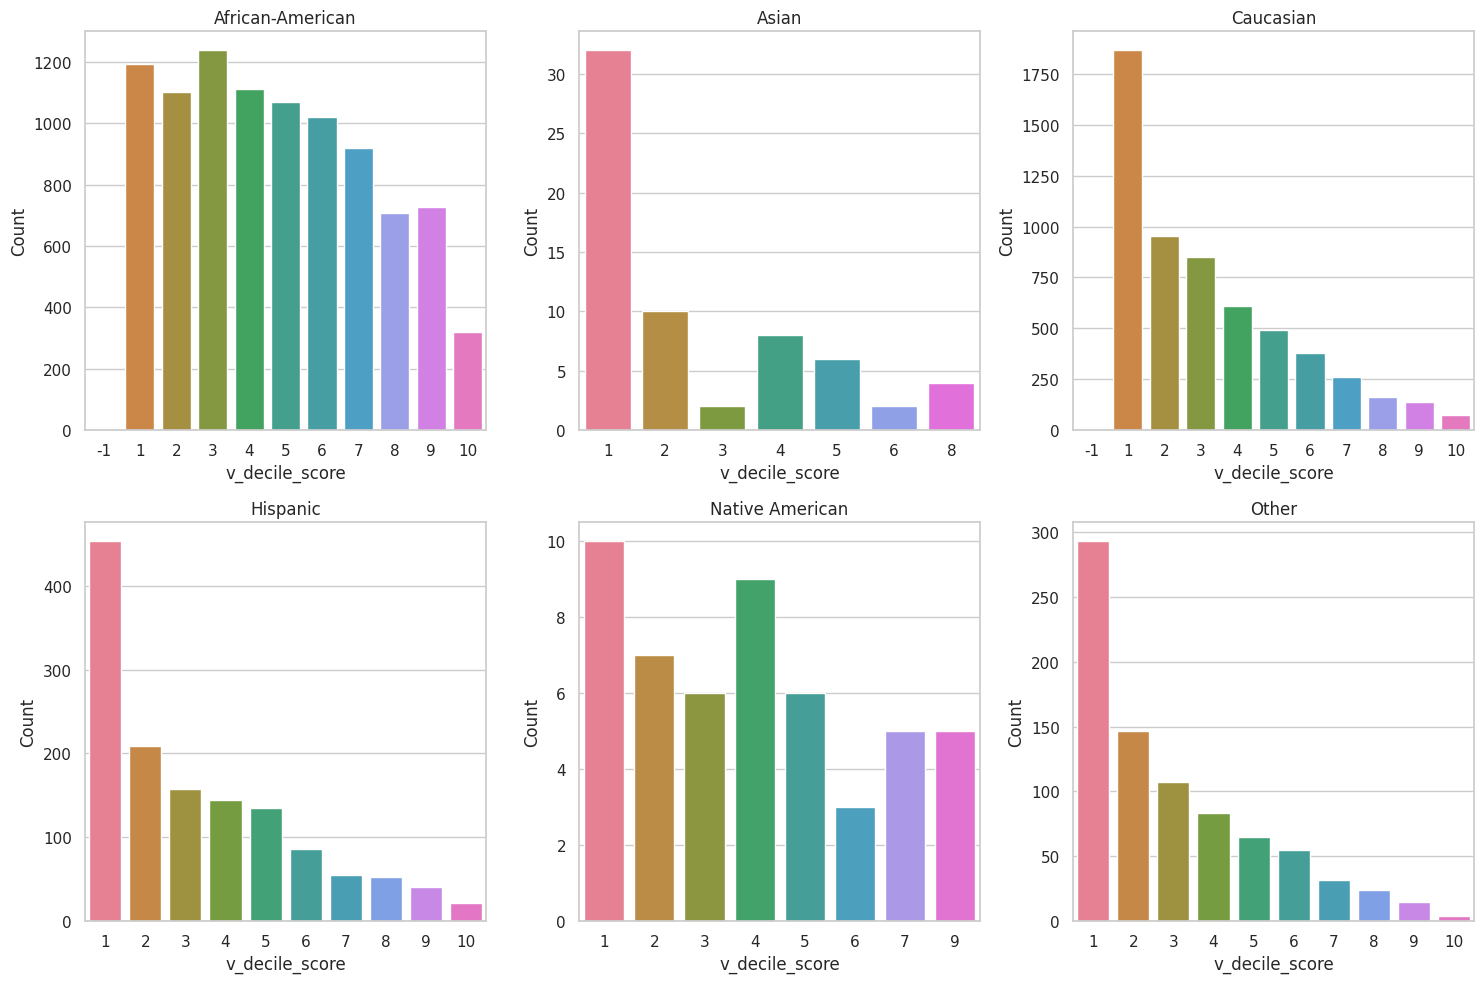

In [24]:
# Define a list of racial groups
racial_groups = ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a grid of count plots for each race's v_decile_scores
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, race in enumerate(racial_groups):
    # Filter the dataframe for the current racial group
    race_data = compas[compas['race'] == race]
    
    # Create a count plot for the v_decile_scores of the current racial group
    sns.countplot(x='v_decile_score', data=race_data, ax=axes[i], palette='husl')
    axes[i].set_title(race)
    axes[i].set_xlabel('v_decile_score')
    axes[i].set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
#Converting Sex to numerical value from object

compas["sex"].replace({'Male': 1, 'Female': 0}, inplace=True)

### 4.Training_the_Dataset_and_Modelling

In [26]:
# Selecting X and Y
X = compas[['age', 'sex', 'decile_score', 'priors_count', 'race', 'days_in_jail', 'c_days_from_compas']]
Y = compas['is_recid']

In [27]:
#Checking the five  row of the data set X

X.head()

,age,sex,decile_score,priors_count,race,days_in_jail,c_days_from_compas
0,69,1,1,0,Other,0.0,1.0
1,69,1,1,0,Other,0.0,1.0
3,34,1,3,0,African-American,10.0,1.0
4,24,1,4,4,African-American,1.0,1.0
5,24,1,4,4,African-American,1.0,1.0


In [28]:
# Encode the 'race' column
X_encoded = X.copy() 
X_encoded['race_encoded'] = label_encoder.fit_transform(X['race'])

In [29]:
# Drop the original 'race' column
X_encoded.drop(['race'], axis=1, inplace=True)

In [30]:
# Splitting the Dataset for Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, stratify=X_encoded[['race_encoded']], random_state=42)

In [31]:
# Scale numerical features

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Initialize the Model (Random Forest Classifier)
model = RandomForestClassifier()

In [33]:
# Train the Model
model.fit(X_train_scaled, Y_train)

RandomForestClassifier()

In [34]:
# Evaluate the Model
Y_pred = model.predict(X_test_scaled)

In [35]:
# Calculate evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

Confusion Matrix:
 [[1539  256]
 [ 237 1468]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      1795
           1       0.85      0.86      0.86      1705

    accuracy                           0.86      3500
   macro avg       0.86      0.86      0.86      3500
weighted avg       0.86      0.86      0.86      3500



#### 4.1.Racial_Group_Modelling

In [36]:
# Define a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the LabelEncoder to the 'race' column
label_encoder.fit(X['race'])

# Iterate over each racial group
for group in racial_groups:
    # Filter test data for the current racial group
    group_indices = X_test['race_encoded'] == label_encoder.transform([group])[0]
    group_Y_test = Y_test[group_indices]
    group_Y_pred = Y_pred[group_indices]  # Assuming Y_pred contains predictions for all samples
    
    # Print classification report for the current racial group
    print(f"Classification Report for {group}:")
    print(classification_report(group_Y_test, group_Y_pred))
    
    # Print confusion matrix for the current racial group
    print(f"Confusion Matrix for {group}:")
    print(confusion_matrix(group_Y_test, group_Y_pred))
    print(f"-----------------------------------------------------")

Classification Report for African-American:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       845
           1       0.86      0.89      0.88      1039

    accuracy                           0.86      1884
   macro avg       0.86      0.86      0.86      1884
weighted avg       0.86      0.86      0.86      1884

Confusion Matrix for African-American:
[[699 146]
 [116 923]]
-----------------------------------------------------
Classification Report for Asian:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.83      0.91         6

    accuracy                           0.92        13
   macro avg       0.94      0.92      0.92        13
weighted avg       0.93      0.92      0.92        13

Confusion Matrix for Asian:
[[7 0]
 [1 5]]
-----------------------------------------------------
Classification Report for Caucasian:
              preci

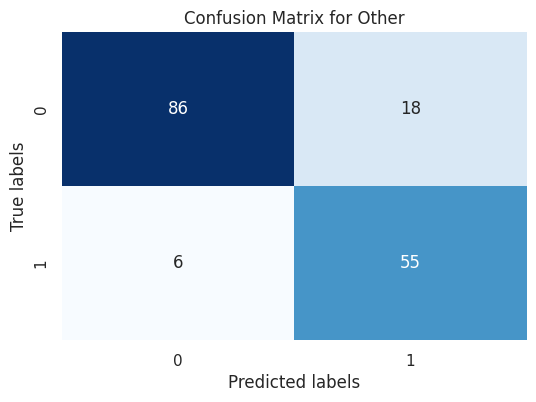

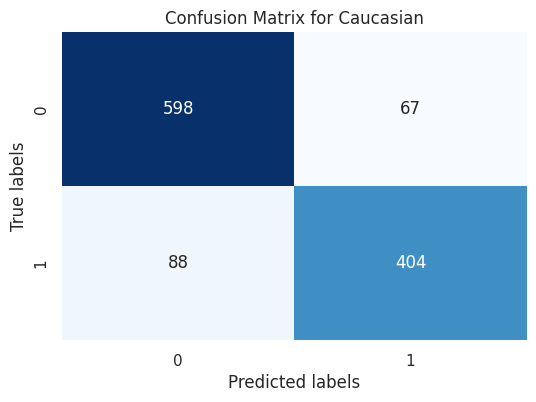

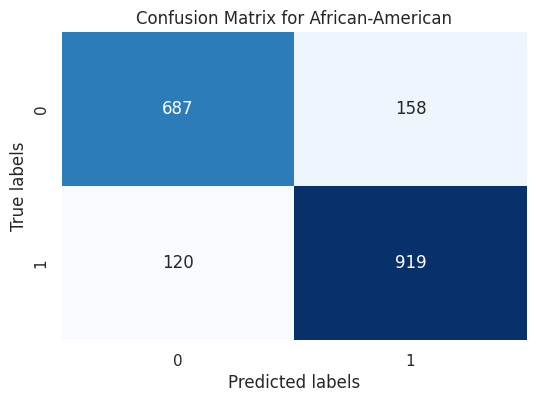

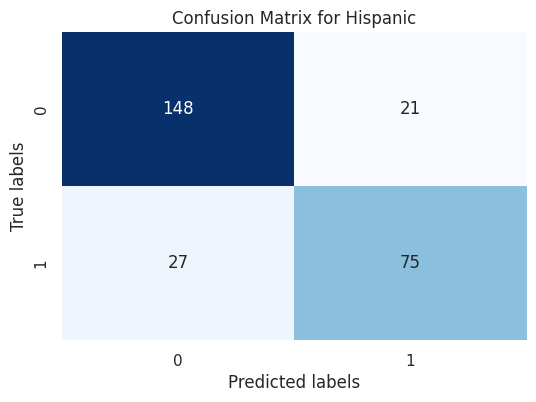

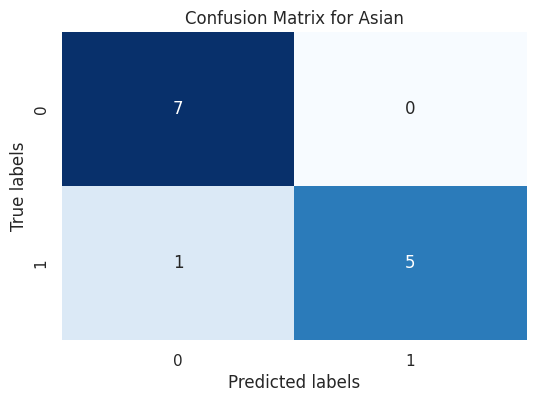

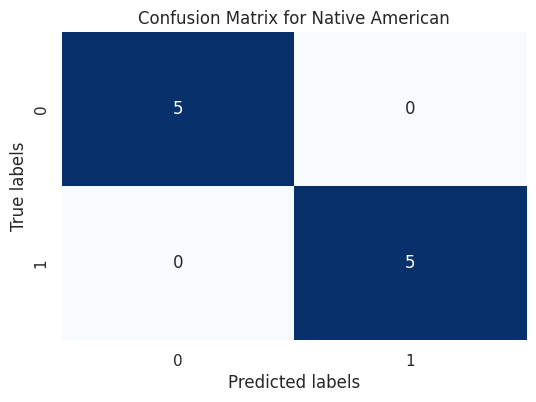

In [37]:
# Confusion matrices data
confusion_matrices = {
    'Other': np.array([[86, 18],
 [ 6, 55,]]),
    'Caucasian': np.array([[598,  67],
 [ 88, 404]]),
    'African-American': np.array([[687, 158],
 [120, 919]]),
    'Hispanic': np.array([[148,  21],
 [ 27,  75]]),
    'Asian': np.array([[7, 0],
 [1, 5]]),
    'Native American': np.array([[5, 0],
 [0, 5]])
}

# Plot confusion matrices for each race
for race, confusion_matrix_data in confusion_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {race}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

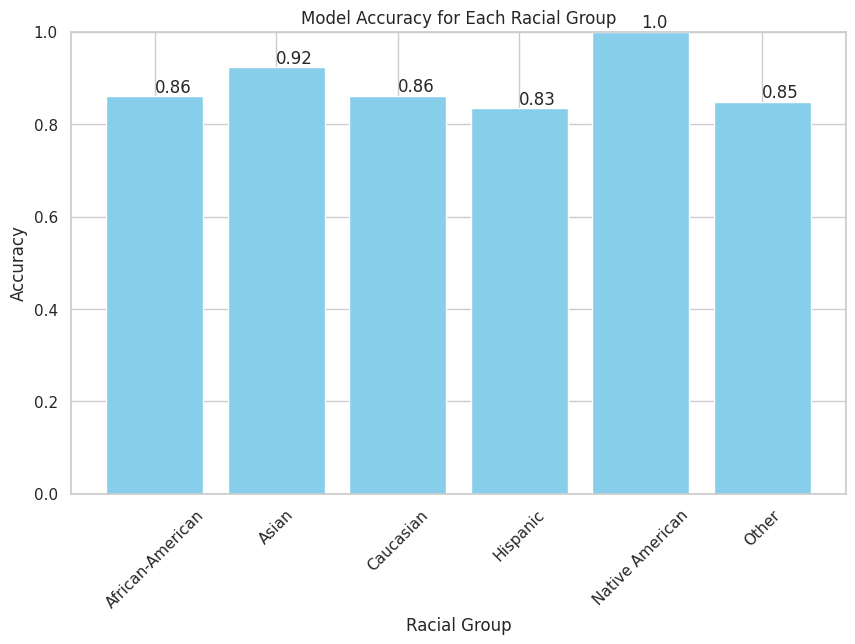

In [38]:
# Define lists to store racial groups and accuracy scores
racial_groups = ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']
accuracy_scores = []

# Iterate over each racial group
for group in racial_groups:
    # Filter test data for the current racial group
    group_indices = X_test['race_encoded'] == label_encoder.transform([group])[0]
    group_Y_test = Y_test[group_indices]
    group_Y_pred = Y_pred[group_indices]
    
    # Calculate accuracy for the current racial group
    accuracy = accuracy_score(group_Y_test, group_Y_pred)
    accuracy_scores.append(accuracy)

# Create a DataFrame to store racial groups and accuracy scores
accuracy_df = pd.DataFrame({'Racial Group': racial_groups, 'Accuracy': accuracy_scores})

# Plot the accuracy scores for each racial group
plt.figure(figsize=(10, 6))
bars = plt.bar(accuracy_df['Racial Group'], accuracy_df['Accuracy'], color='skyblue')

# Add labels to each bar with accuracy figures
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.title('Model Accuracy for Each Racial Group')
plt.xlabel('Racial Group')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Set y-axis limits to ensure proper visualization
plt.show()


**This visualization allows me to easily compare the performance metrics of the racial group based on their accuracy, the chart also shows that Native American and Caucasian have the best model with the highest value of model accuracy.**